# NowSecure Dataset Analysis and Modeling of Risky Apps

## Data Wrangling

### Approach

Our strategy is to determine the apps that are risky to have on the app store given their security posture. In this notebook we explore building machine learning models to determine how risky a given app might be from the data we have available to us about a given app.

Given the 7 groups of JSON data files, we must first wrangle the data into a single file

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
import seaborn as sns

In [ ]:
# Base directory containing group folders
base_directory = '.'  # Adjust path as needed, if the script isn't in the same location

# Create an empty dataframe to store the stacked data
final_df = pd.DataFrame()

# Loop through each directory named 'Group X'
for i in range(1, 8):  # Since there are 7 groups
    directory_path = os.path.join(base_directory, f'Group {i}')
    
    # Loop through each JSON file in the directory
    for filename in os.listdir(directory_path):
        if filename.endswith(".json"):
            with open(os.path.join(directory_path, filename), 'r') as f:
                data = json.load(f)
                
                # Convert JSON to dataframe and flatten the hierarchical structure
                temp_df = pd.json_normalize(data, max_level=2)  # Adjust max_level based on the depth of the JSON
                
                # Append the temp_df to final_df
                final_df = final_df.append(temp_df, ignore_index=True)

In [ ]:
final_df.shape

In [ ]:
final_df.to_csv('combined_data.csv', index=False)

## Exploratory Data Analysis

After wrangling the data into a single CSV file we import the data into a dataframe and explore the dataset for interesting factors that might contribute to riskiness

In [13]:
df = pd.read_csv('combined_data.csv')

In [14]:
df.head(10)

,title,latestAnalysisRecorded,assessment.analysis.task,assessment.ref,assessment.publisherName,assessment.buildVersion,assessment.platformType,assessment.packageKey,assessment.appstoreApplicationKey,assessment.createdAt,assessment.report.score,assessment.report.findings,assessment
0,Speak & Translate - Translator,2021-06-27T09:06:04.786Z,{'dynamic': {'result': {'itunes': {'listing': ...,e6fd52ec-d726-11eb-9b8a-cbcada7fe97a,Apalon Apps,5.0.15-5.0.15.0,ios,com.appicfun.translatorfree,804641004,2021-06-27T09:06:04.786694Z,79.0,"[{'cvss': 5.3, 'impactType': 'medium', 'affect...",NaN
1,"theScore: Live Sports Scores, News, Stats & Vi...",2021-08-30T00:11:32.388Z,"{'dynamic': {'result': {'fs_issues': [], 'http...",d50c2676-0926-11ec-b7f2-ab4c4b2e8411,Score Media Ventures Inc.,21110,android,com.fivemobile.thescore,com.fivemobile.thescore,2021-08-30T00:11:32.388267Z,81.2,"[{'cvss': 5.9, 'impactType': 'medium', 'affect...",NaN
2,FreeCell,2021-04-27T21:38:09.681Z,{'dynamic': {'result': {'fs_issues': [{'mode':...,dc7ee16a-a7a0-11eb-b680-c3c81dfda4be,Queens Solitaire Games,111,android,com.hapogames.FreeCell,com.hapogames.FreeCell,2021-04-27T21:38:09.681925Z,48.4,"[{'cvss': 7, 'impactType': 'high', 'affected':...",NaN
3,Police Car Driving Simulator 3D: Car Games 2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Hearthstone,2021-09-03T05:33:56.421Z,"{'dynamic': {'result': {'fs_issues': [], 'http...",88918dae-0c78-11ec-93df-d71260f3fb6a,"Blizzard Entertainment, Inc.",9145600,android,com.blizzard.wtcg.hearthstone,com.blizzard.wtcg.hearthstone,2021-09-03T05:33:56.421539Z,78.3,"[{'cvss': 5.9, 'impactType': 'medium', 'affect...",NaN
5,Multi-Play Video Poker™ - Free Video Poker Games,2021-07-31T21:46:44.071Z,{'dynamic': {'result': {'fs_issues': [{'mode':...,cc74e04c-f248-11eb-ab0f-b7744fed5e2b,Ruby Seven Studios Inc.,41,android,com.rubyseven.multistrikepoker,com.rubyseven.multistrikepoker,2021-07-31T21:46:44.071720Z,85.6,"[{'cvss': 4.6, 'impactType': 'medium', 'affect...",NaN
6,EXiTS - Room Escape Game,2021-08-31T15:40:20.646Z,"{'dynamic': {'result': {'fs_issues': [], 'http...",bff1e19e-0a71-11ec-8110-bfe8f76e53a6,NAKAYUBI CORPORATION,118,android,com.ryohei.haruki.Exit,com.ryohei.haruki.Exit,2021-08-31T15:40:20.646097Z,85.6,"[{'cvss': 4.6, 'impactType': 'medium', 'affect...",NaN
7,Video Maker,2021-09-10T03:49:16.586Z,{'dynamic': {'result': {'fs_issues': [{'mode':...,1285ebce-11ea-11ec-ae09-d375fa76eefd,InShot Inc.,88,android,videoeditor.videomaker.videoeditorforyoutube,videoeditor.videomaker.videoeditorforyoutube,2021-09-10T03:49:16.586153Z,78.0,"[{'cvss': 5, 'impactType': 'medium', 'affected...",NaN
8,Tracks4Africa Guide,2020-06-11T13:59:40.185Z,"{'dynamic': {'result': {'fs_issues': [], 'http...",cb47d02a-abeb-11ea-8f3e-af5d08e96e4a,Tracks4Africa,640,android,za.co.tracks4africa.guide.hybrid,za.co.tracks4africa.guide.hybrid,2020-06-11T13:59:40.185658Z,46.3,"[{'cvss': 7.5, 'impactType': 'high', 'affected...",NaN
9,Kardia,2021-08-27T13:39:06.132Z,{'dynamic': {'result': {'itunes': {'listing': ...,263c56e8-073c-11ec-8d97-7bda0dc1e472,"AliveCor, Inc.",5.18.2-1664,ios,com.alivecor.professional.aliveecg,579769143,2021-08-27T13:39:06.132276Z,50.8,"[{'cvss': 6.5, 'impactType': 'medium', 'affect...",NaN


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 13 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   title                              194 non-null    object 
 1   latestAnalysisRecorded             166 non-null    object 
 2   assessment.analysis.task           166 non-null    object 
 3   assessment.ref                     166 non-null    object 
 4   assessment.publisherName           166 non-null    object 
 5   assessment.buildVersion            166 non-null    object 
 6   assessment.platformType            166 non-null    object 
 7   assessment.packageKey              166 non-null    object 
 8   assessment.appstoreApplicationKey  166 non-null    object 
 9   assessment.createdAt               166 non-null    object 
 10  assessment.report.score            150 non-null    float64
 11  assessment.report.findings         166 non-null    object 

In [16]:
df.describe()

,assessment.report.score,assessment
count,150.000000,0.0
mean,67.629333,NaN
std,20.167199,NaN
min,6.500000,NaN
25%,46.300000,NaN
50%,77.800000,NaN
75%,83.675000,NaN
max,100.000000,NaN


In [17]:
df.isnull().sum()

title                                  0
latestAnalysisRecorded                28
assessment.analysis.task              28
assessment.ref                        28
assessment.publisherName              28
assessment.buildVersion               28
assessment.platformType               28
assessment.packageKey                 28
assessment.appstoreApplicationKey     28
assessment.createdAt                  28
assessment.report.score               44
assessment.report.findings            28
assessment                           194
dtype: int64

We see that the data has some missing values for 28 apps, missing report score for 44 apps, and that the 'assessment' column is empty

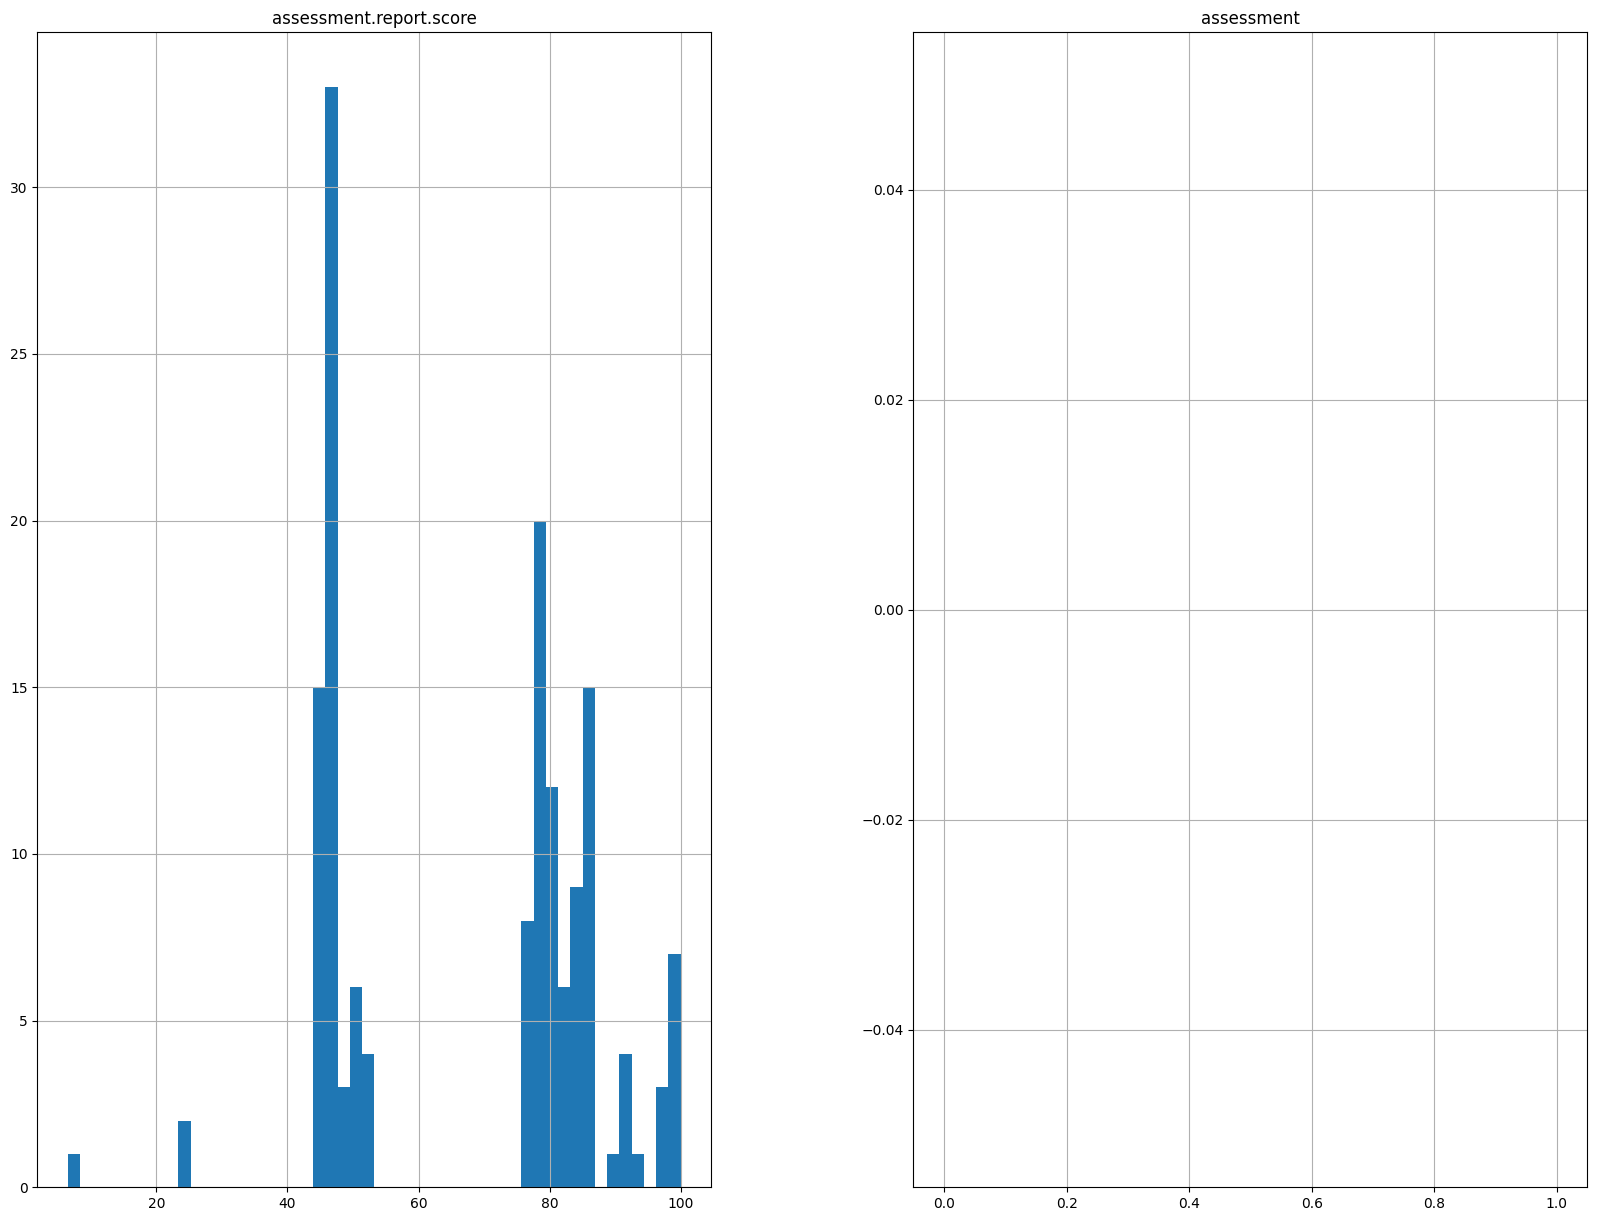

In [18]:
df.hist(bins=50, figsize=(20, 15))
plt.show()

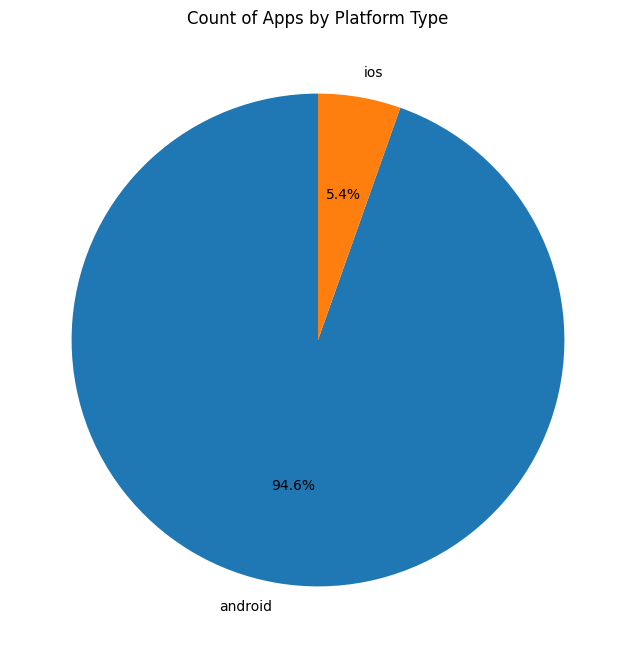

In [19]:
# Group by 'assessment.platformType' and count the number of apps
platform_counts = df['assessment.platformType'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
platform_counts.plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Count of Apps by Platform Type')
plt.ylabel('')  # Hide the y-label
plt.show()

In [22]:
publisher_counts = df.groupby('assessment.publisherName').size()

publisher_counts_sorted = publisher_counts.sort_values(ascending=False)

# Display the sorted counts
print(publisher_counts_sorted)

assessment.publisherName
AXS, LLC          2
Aceable, Inc.     2
YovoGames         2
10% Happier       1
RUBICON d.o.o.    1
                 ..
Gabo Apps         1
Game Pickle       1
GameSpire Ltd.    1
Gamerdev19        1
海峰 苏              1
Length: 163, dtype: int64


## Data Preprocessing

To clean up the dataset we will drop empty columns, drop rows with NaN values from any machine learning models we build, but retain the 16 rows that are just missing a single report score value

In [25]:
df_cleaned = df.drop(columns=['assessment'])

row_with_missing_values = df_cleaned[df_cleaned.isnull().any(axis=1)]

row_with_missing_values

,title,latestAnalysisRecorded,assessment.analysis.task,assessment.ref,assessment.publisherName,assessment.buildVersion,assessment.platformType,assessment.packageKey,assessment.appstoreApplicationKey,assessment.createdAt,assessment.report.score,assessment.report.findings
3,Police Car Driving Simulator 3D: Car Games 2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,Gospel Living,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,Cell Tracker Kids,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,Spectator Judging,2020-12-21T09:58:30.110Z,"{'dynamic': None, 'static': {'result': {'yaap_...",14192c76-4373-11eb-ad9a-239002ba014c,Black Horse One GmbH,547,android,com.blackhorse88.livejudging,com.blackhorse88.livejudging,2020-12-21T09:58:30.110245Z,NaN,"[{'cvss': 4.6, 'impactType': 'medium', 'affect..."
27,Find It Differences - 2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,亂鬥英雄志-名將風雲錄,2020-09-29T13:09:08.633Z,"{'dynamic': None, 'static': {'result': {'yaap_...",f6113b38-0254-11eb-b17c-ef03d52f79ab,Morefun Technology Limited,1000023,android,com.gamemorefun.lstd,com.gamemorefun.lstd,2020-09-29T13:09:08.633827Z,NaN,"[{'cvss': 4.6, 'impactType': 'medium', 'affect..."
31,"InSquare Pic - Photo Editor, No Crop, Collage",2021-09-03T07:40:00.777Z,"{'dynamic': None, 'static': {'result': {'yaap_...",25463fa8-0c8a-11ec-8bd1-176f37060474,Square Quick & Pic Collage Maker,81,android,mobi.charmer.quicksquarenew,mobi.charmer.quicksquarenew,2021-09-03T07:40:00.777259Z,NaN,"[{'cvss': 5.9, 'impactType': 'medium', 'affect..."
33,Magic Piano Tiles 4：Pop Songs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,Instaqart PH: Grocery Delivery,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,Uyanık TV Box for Android TV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
df_cleaned = df_cleaned.dropna(subset=['latestAnalysisRecorded'])
df_cleaned

,title,latestAnalysisRecorded,assessment.analysis.task,assessment.ref,assessment.publisherName,assessment.buildVersion,assessment.platformType,assessment.packageKey,assessment.appstoreApplicationKey,assessment.createdAt,assessment.report.score,assessment.report.findings
0,Speak & Translate - Translator,2021-06-27T09:06:04.786Z,{'dynamic': {'result': {'itunes': {'listing': ...,e6fd52ec-d726-11eb-9b8a-cbcada7fe97a,Apalon Apps,5.0.15-5.0.15.0,ios,com.appicfun.translatorfree,804641004,2021-06-27T09:06:04.786694Z,79.0,"[{'cvss': 5.3, 'impactType': 'medium', 'affect..."
1,"theScore: Live Sports Scores, News, Stats & Vi...",2021-08-30T00:11:32.388Z,"{'dynamic': {'result': {'fs_issues': [], 'http...",d50c2676-0926-11ec-b7f2-ab4c4b2e8411,Score Media Ventures Inc.,21110,android,com.fivemobile.thescore,com.fivemobile.thescore,2021-08-30T00:11:32.388267Z,81.2,"[{'cvss': 5.9, 'impactType': 'medium', 'affect..."
2,FreeCell,2021-04-27T21:38:09.681Z,{'dynamic': {'result': {'fs_issues': [{'mode':...,dc7ee16a-a7a0-11eb-b680-c3c81dfda4be,Queens Solitaire Games,111,android,com.hapogames.FreeCell,com.hapogames.FreeCell,2021-04-27T21:38:09.681925Z,48.4,"[{'cvss': 7, 'impactType': 'high', 'affected':..."
4,Hearthstone,2021-09-03T05:33:56.421Z,"{'dynamic': {'result': {'fs_issues': [], 'http...",88918dae-0c78-11ec-93df-d71260f3fb6a,"Blizzard Entertainment, Inc.",9145600,android,com.blizzard.wtcg.hearthstone,com.blizzard.wtcg.hearthstone,2021-09-03T05:33:56.421539Z,78.3,"[{'cvss': 5.9, 'impactType': 'medium', 'affect..."
5,Multi-Play Video Poker™ - Free Video Poker Games,2021-07-31T21:46:44.071Z,{'dynamic': {'result': {'fs_issues': [{'mode':...,cc74e04c-f248-11eb-ab0f-b7744fed5e2b,Ruby Seven Studios Inc.,41,android,com.rubyseven.multistrikepoker,com.rubyseven.multistrikepoker,2021-07-31T21:46:44.071720Z,85.6,"[{'cvss': 4.6, 'impactType': 'medium', 'affect..."
...,...,...,...,...,...,...,...,...,...,...,...,...
186,VPN by CyberGhost - WiFi Proxy,2021-09-06T07:27:00.044Z,{'dynamic': {'result': {'itunes': {'listing': ...,d2f83696-0ee3-11ec-88ca-33dbff41a4c0,CyberGhost SRL,8.3.2-252,ios,com.cyberghostsrl.cyberghostvpn,583009522,2021-09-06T07:27:00.044174Z,82.7,"[{'cvss': 4.8, 'impactType': 'medium', 'affect..."
190,free monthly calendar app,2020-11-06T21:22:25.087Z,{'dynamic': {'result': {'fs_issues': [{'mode':...,2a3c8e28-2076-11eb-ba0e-0392d0a5d1e7,Adcoms,10,android,com.CalendarMonthlyStyle,com.CalendarMonthlyStyle,2020-11-06T21:22:25.087856Z,46.3,"[{'cvss': 7.5, 'impactType': 'high', 'affected..."
191,Mighty Networks,2021-08-29T23:28:17.213Z,"{'dynamic': {'result': {'fs_issues': [], 'http...",ca90818e-0920-11ec-901c-47edd37979c6,Mighty Networks,500985,android,com.mightybell.mb,com.mightybell.mb,2021-08-29T23:28:17.213337Z,85.6,"[{'cvss': 4.6, 'impactType': 'medium', 'affect..."
192,Trip Agent,2021-06-08T14:48:49.924Z,{'dynamic': {'result': {'fs_issues': [{'mode':...,a36321be-c868-11eb-a83b-8b9fb43ce064,mTrip apps,141,android,com.mtrip.tripagent,com.mtrip.tripagent,2021-06-08T14:48:49.924905Z,79.2,"[{'cvss': 5, 'impactType': 'medium', 'affected..."


## Feature Engineering

The lower the report score for a given app, the less secure the app is considered according to NowSecure. As such, the approach taken to determine the riskiness of an app will be by building a regression model to determine the Assessment Report Score.

As part of the regression model that we will build, we will use various other columns in the dataset as features (X) and to predict the target variable (Y) of report score. Some of these other features will be the count of the number of findings that we will extract from the 'assessment.report.findings' column to get a count of the number of different types of findings by severity for each app on the app store.

In [27]:
import re
from collections import Counter

def count_severities(findings_str):
    # Regular expression to match the 'impactType' and its value
    regex = r"'impactType': '([^']*)'"

    # Find all matches in the string
    matches = re.findall(regex, findings_str)

    # Count occurrences of each severity
    severity_count = Counter(matches)

    return dict(severity_count)

In [28]:
df_cleaned['severity_counts'] = df_cleaned['assessment.report.findings'].apply(count_severities)
df_cleaned['severity_counts'][0]

{'medium': 3, 'low': 2, 'warn': 4, 'info': 18, 'artifact': 2, 'pass': 89}

In [29]:
# Step 1: Get all unique severity types from all rows
all_severities = set()
df_cleaned['severity_counts'].apply(lambda x: all_severities.update(x.keys()))

# Step 2: Iterate through each row and update new columns
for severity in all_severities:
    column_name = f'count_{severity}_findings'
    df_cleaned[column_name] = df_cleaned['severity_counts'].apply(lambda x: x.get(severity, 0))

# Now df_cleaned contains new columns for each severity type
df_cleaned

,title,latestAnalysisRecorded,assessment.analysis.task,assessment.ref,assessment.publisherName,assessment.buildVersion,assessment.platformType,assessment.packageKey,assessment.appstoreApplicationKey,assessment.createdAt,...,assessment.report.findings,severity_counts,count_high_findings,count_artifact_findings,count_low_findings,count_warn_findings,count_medium_findings,count_critical_findings,count_pass_findings,count_info_findings
0,Speak & Translate - Translator,2021-06-27T09:06:04.786Z,{'dynamic': {'result': {'itunes': {'listing': ...,e6fd52ec-d726-11eb-9b8a-cbcada7fe97a,Apalon Apps,5.0.15-5.0.15.0,ios,com.appicfun.translatorfree,804641004,2021-06-27T09:06:04.786694Z,...,"[{'cvss': 5.3, 'impactType': 'medium', 'affect...","{'medium': 3, 'low': 2, 'warn': 4, 'info': 18,...",0,2,2,4,3,0,89,18
1,"theScore: Live Sports Scores, News, Stats & Vi...",2021-08-30T00:11:32.388Z,"{'dynamic': {'result': {'fs_issues': [], 'http...",d50c2676-0926-11ec-b7f2-ab4c4b2e8411,Score Media Ventures Inc.,21110,android,com.fivemobile.thescore,com.fivemobile.thescore,2021-08-30T00:11:32.388267Z,...,"[{'cvss': 5.9, 'impactType': 'medium', 'affect...","{'medium': 1, 'low': 1, 'warn': 1, 'info': 14,...",0,2,1,1,1,0,111,14
2,FreeCell,2021-04-27T21:38:09.681Z,{'dynamic': {'result': {'fs_issues': [{'mode':...,dc7ee16a-a7a0-11eb-b680-c3c81dfda4be,Queens Solitaire Games,111,android,com.hapogames.FreeCell,com.hapogames.FreeCell,2021-04-27T21:38:09.681925Z,...,"[{'cvss': 7, 'impactType': 'high', 'affected':...","{'high': 1, 'low': 3, 'warn': 3, 'info': 12, '...",1,2,3,3,0,0,112,12
4,Hearthstone,2021-09-03T05:33:56.421Z,"{'dynamic': {'result': {'fs_issues': [], 'http...",88918dae-0c78-11ec-93df-d71260f3fb6a,"Blizzard Entertainment, Inc.",9145600,android,com.blizzard.wtcg.hearthstone,com.blizzard.wtcg.hearthstone,2021-09-03T05:33:56.421539Z,...,"[{'cvss': 5.9, 'impactType': 'medium', 'affect...","{'medium': 2, 'low': 3, 'warn': 1, 'info': 10,...",0,2,3,1,2,0,113,10
5,Multi-Play Video Poker™ - Free Video Poker Games,2021-07-31T21:46:44.071Z,{'dynamic': {'result': {'fs_issues': [{'mode':...,cc74e04c-f248-11eb-ab0f-b7744fed5e2b,Ruby Seven Studios Inc.,41,android,com.rubyseven.multistrikepoker,com.rubyseven.multistrikepoker,2021-07-31T21:46:44.071720Z,...,"[{'cvss': 4.6, 'impactType': 'medium', 'affect...","{'medium': 1, 'warn': 1, 'info': 11, 'artifact...",0,2,0,1,1,0,111,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,VPN by CyberGhost - WiFi Proxy,2021-09-06T07:27:00.044Z,{'dynamic': {'result': {'itunes': {'listing': ...,d2f83696-0ee3-11ec-88ca-33dbff41a4c0,CyberGhost SRL,8.3.2-252,ios,com.cyberghostsrl.cyberghostvpn,583009522,2021-09-06T07:27:00.044174Z,...,"[{'cvss': 4.8, 'impactType': 'medium', 'affect...","{'medium': 2, 'low': 2, 'warn': 3, 'info': 18,...",0,2,2,3,2,0,89,18
190,free monthly calendar app,2020-11-06T21:22:25.087Z,{'dynamic': {'result': {'fs_issues': [{'mode':...,2a3c8e28-2076-11eb-ba0e-0392d0a5d1e7,Adcoms,10,android,com.CalendarMonthlyStyle,com.CalendarMonthlyStyle,2020-11-06T21:22:25.087856Z,...,"[{'cvss': 7.5, 'impactType': 'high', 'affected...","{'high': 1, 'medium': 2, 'low': 3, 'warn': 1, ...",1,2,3,1,2,0,136,10
191,Mighty Networks,2021-08-29T23:28:17.213Z,"{'dynamic': {'result': {'fs_issues': [], 'http...",ca90818e-0920-11ec-901c-47edd37979c6,Mighty Networks,500985,android,com.mightybell.mb,com.mightybell.mb,2021-08-29T23:28:17.213337Z,...,"[{'cvss': 4.6, 'impactType': 'medium', 'affect...","{'medium': 1, 'warn': 1, 'info': 11, 'artifact...",0,2,0,1,1,0,109,11
192,Trip Agent,2021-06-08T14:48:49.924Z,{'dynamic': {'result': {'fs_issues': [{'mode':...,a36321be-c868-11eb-a83b-8b9fb43ce064,mTrip apps,141,android,com.mtrip.tripagent,com.mtrip.tripagent,2021-06-08T14:48:49.924905Z,...,"[{'cvss': 5, 'impactType': 'medium', 'affected...","{'medium': 2, 'low': 4, 'warn': 2, 'info': 13,...",0,2,4,2,2,0,108,13


In [31]:
#'count_critical_findings', 'count_high_findings', 'count_medium_findings', 'count_warn_findings','count_pass_findings', 'count_info_findings', 'count_artifact_findings', 'assessment.report.score'] 

# Select the last 8 columns
last_eight_columns = df_cleaned.iloc[:, -8:]

# Select the additional named columns
additional_columns = df_cleaned[['assessment.platformType', 'assessment.report.score']]

# Concatenate the columns to create a new DataFrame
new_df = pd.concat([additional_columns, last_eight_columns], axis=1)
new_df

,assessment.platformType,assessment.report.score,count_high_findings,count_artifact_findings,count_low_findings,count_warn_findings,count_medium_findings,count_critical_findings,count_pass_findings,count_info_findings
0,ios,79.0,0,2,2,4,3,0,89,18
1,android,81.2,0,2,1,1,1,0,111,14
2,android,48.4,1,2,3,3,0,0,112,12
4,android,78.3,0,2,3,1,2,0,113,10
5,android,85.6,0,2,0,1,1,0,111,11
...,...,...,...,...,...,...,...,...,...,...
186,ios,82.7,0,2,2,3,2,0,89,18
190,android,46.3,1,2,3,1,2,0,136,10
191,android,85.6,0,2,0,1,1,0,109,11
192,android,79.2,0,2,4,2,2,0,108,13


In [32]:
one_hot = pd.get_dummies(new_df['assessment.platformType'], prefix='platformType')
new_df = new_df.join(one_hot)
new_df

,assessment.platformType,assessment.report.score,count_high_findings,count_artifact_findings,count_low_findings,count_warn_findings,count_medium_findings,count_critical_findings,count_pass_findings,count_info_findings,platformType_android,platformType_ios
0,ios,79.0,0,2,2,4,3,0,89,18,False,True
1,android,81.2,0,2,1,1,1,0,111,14,True,False
2,android,48.4,1,2,3,3,0,0,112,12,True,False
4,android,78.3,0,2,3,1,2,0,113,10,True,False
5,android,85.6,0,2,0,1,1,0,111,11,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
186,ios,82.7,0,2,2,3,2,0,89,18,False,True
190,android,46.3,1,2,3,1,2,0,136,10,True,False
191,android,85.6,0,2,0,1,1,0,109,11,True,False
192,android,79.2,0,2,4,2,2,0,108,13,True,False


In [33]:
new_df.count_critical_findings.value_counts()

count_critical_findings
0    165
1      1
Name: count, dtype: int64

In [34]:
# Set up x and Y variables for regression

X = new_df.iloc[:,2:]
Y = new_df['assessment.report.score']

In [35]:
# Set up Test Train splits, implement k fold cross validation, start doing step wise linear regression, pick loss metric

from sklearn.preprocessing import StandardScaler

# Assuming df is your original DataFrame and Y is the target column
X = new_df.drop(columns=['assessment.report.score'])  # Replace 'Y' with the actual name of your target column
X = new_df.iloc[:,2:]

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler to your data and transform it
X_scaled = scaler.fit_transform(X)

# Convert the scaled data back to a DataFrame with original indices
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_scaled_df

,count_high_findings,count_artifact_findings,count_low_findings,count_warn_findings,count_medium_findings,count_critical_findings,count_pass_findings,count_info_findings,platformType_android,platformType_ios
0,-0.644920,0.312019,0.399739,1.333754,0.762273,-0.07785,-0.372809,2.146308,-4.176655,4.176655
1,-0.644920,0.312019,-0.409488,-0.553205,-0.605698,-0.07785,0.437606,0.749104,0.239426,-0.239426
2,1.027842,0.312019,1.208965,0.704768,-1.289683,-0.07785,0.474443,0.050501,0.239426,-0.239426
4,-0.644920,0.312019,1.208965,-0.553205,0.078287,-0.07785,0.511280,-0.648101,0.239426,-0.239426
5,-0.644920,0.312019,-1.218715,-0.553205,-0.605698,-0.07785,0.437606,-0.298800,0.239426,-0.239426
...,...,...,...,...,...,...,...,...,...,...
186,-0.644920,0.312019,0.399739,0.704768,0.078287,-0.07785,-0.372809,2.146308,-4.176655,4.176655
190,1.027842,0.312019,1.208965,-0.553205,0.078287,-0.07785,1.358532,-0.648101,0.239426,-0.239426
191,-0.644920,0.312019,-1.218715,-0.553205,-0.605698,-0.07785,0.363932,-0.298800,0.239426,-0.239426
192,-0.644920,0.312019,2.018192,0.075782,0.078287,-0.07785,0.327095,0.399802,0.239426,-0.239426


In [36]:
# Convert Y to a DataFrame with the same index as X_scaled_df
Y_df = Y.reindex(X_scaled_df.index).to_frame(name='target')

# Split the data into train and test based on missing values in Y
train_data = X_scaled_df[~Y_df['target'].isna()]
test_data = X_scaled_df[Y_df['target'].isna()]

train_target = Y_df[~Y_df['target'].isna()]
test_target = Y_df[Y_df['target'].isna()]


In [37]:
train_data

,count_high_findings,count_artifact_findings,count_low_findings,count_warn_findings,count_medium_findings,count_critical_findings,count_pass_findings,count_info_findings,platformType_android,platformType_ios
0,-0.644920,0.312019,0.399739,1.333754,0.762273,-0.07785,-0.372809,2.146308,-4.176655,4.176655
1,-0.644920,0.312019,-0.409488,-0.553205,-0.605698,-0.07785,0.437606,0.749104,0.239426,-0.239426
2,1.027842,0.312019,1.208965,0.704768,-1.289683,-0.07785,0.474443,0.050501,0.239426,-0.239426
4,-0.644920,0.312019,1.208965,-0.553205,0.078287,-0.07785,0.511280,-0.648101,0.239426,-0.239426
5,-0.644920,0.312019,-1.218715,-0.553205,-0.605698,-0.07785,0.437606,-0.298800,0.239426,-0.239426
...,...,...,...,...,...,...,...,...,...,...
186,-0.644920,0.312019,0.399739,0.704768,0.078287,-0.07785,-0.372809,2.146308,-4.176655,4.176655
190,1.027842,0.312019,1.208965,-0.553205,0.078287,-0.07785,1.358532,-0.648101,0.239426,-0.239426
191,-0.644920,0.312019,-1.218715,-0.553205,-0.605698,-0.07785,0.363932,-0.298800,0.239426,-0.239426
192,-0.644920,0.312019,2.018192,0.075782,0.078287,-0.07785,0.327095,0.399802,0.239426,-0.239426


In [38]:
test_data

,count_high_findings,count_artifact_findings,count_low_findings,count_warn_findings,count_medium_findings,count_critical_findings,count_pass_findings,count_info_findings,platformType_android,platformType_ios
20,-0.644920,-2.565488,-0.409488,-0.553205,-0.605698,-0.07785,-3.282935,-2.743908,0.239426,-0.239426
28,-0.644920,-2.565488,-0.409488,-0.553205,-0.605698,-0.07785,-3.282935,-2.743908,0.239426,-0.239426
31,-0.644920,-2.565488,-1.218715,-0.553205,0.078287,-0.07785,-3.319772,-2.394606,0.239426,-0.239426
41,1.027842,-5.442996,-1.218715,-1.182191,-1.289683,-0.07785,-2.030475,-2.045305,0.239426,-0.239426
44,-0.644920,-2.565488,-1.218715,-1.182191,-0.605698,-0.07785,-3.246098,-2.394606,0.239426,-0.239426
61,-0.644920,-5.442996,-1.218715,-1.182191,-1.289683,-0.07785,-1.993638,-2.394606,0.239426,-0.239426
63,-0.644920,-2.565488,-1.218715,-1.182191,-1.289683,-0.07785,-3.209261,-2.394606,0.239426,-0.239426
69,-0.644920,-2.565488,-1.218715,0.075782,-1.289683,-0.07785,0.805977,-1.346703,0.239426,-0.239426
98,-0.644920,-2.565488,-1.218715,-1.182191,-0.605698,-0.07785,-3.246098,-2.394606,0.239426,-0.239426
102,-0.644920,-2.565488,-0.409488,-1.182191,0.078287,-0.07785,-3.393446,-2.394606,0.239426,-0.239426


In [39]:
train_target

,target
0,79.0
1,81.2
2,48.4
4,78.3
5,85.6
...,...
186,82.7
190,46.3
191,85.6
192,79.2


In [40]:
test_target

,target
20,NaN
28,NaN
31,NaN
41,NaN
44,NaN
61,NaN
63,NaN
69,NaN
98,NaN
102,NaN


In [41]:
import statsmodels.api as sm

# Function to perform stepwise regression
def stepwise_regression(train_data, train_target):
    included = []
    while True:
        changed = False
        # Loop over all features not yet included
        for new_column in train_data.columns.difference(included):
            model = sm.OLS(train_target, sm.add_constant(train_data[included + [new_column]])).fit()
            p_values = model.pvalues.iloc[1:]  # exclude intercept
            worst_pval = p_values.max()  # highest p-value
            if worst_pval < 0.05:  # significance level
                included.append(new_column)
                changed = True
        if not changed:
            break

    final_model = sm.OLS(train_target, sm.add_constant(train_data[included])).fit()
    return final_model

# Run the stepwise regression
model = stepwise_regression(train_data, train_target['target'])

# Print summary of final model
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     170.0
Date:                Wed, 22 Nov 2023   Prob (F-statistic):           5.75e-39
Time:                        00:30:22   Log-Likelihood:                -573.10
No. Observations:                 150   AIC:                             1152.
Df Residuals:                     147   BIC:                             1161.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
count_high_findings       

In [47]:
# Extract the features selected by the stepwise regression model - Count Pass Findings and Count Artifact Findings

X_train = train_data.loc[:, ['count_artifact_findings', 'count_low_findings']]
X_test = test_data.loc[:, ['count_artifact_findings', 'count_low_findings']]
y_train = train_target['target']
y_test = test_target['target']

In [52]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Create a linear regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Use the trained model to predict the target values for the test data
test_predictions = model.predict(X_test)

# mse = mean_squared_error(test_target.dropna(), test_predictions)

# Update the NaN values in the test target column with the predicted values
y_test['test_target'] = test_predictions

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [51]:
y_test

array([70.72022033, 70.72022033, 75.4999425 , 75.4999425 , 75.4999425 ,
       75.4999425 , 75.4999425 , 75.4999425 , 75.4999425 , 70.72022033,
       75.4999425 , 75.4999425 , 75.4999425 , 75.4999425 , 75.4999425 ,
       75.4999425 ])

In [41]:
relevant_test_data['test_target']

20     70.720220
28     70.720220
31     75.499942
41     75.499942
44     75.499942
61     75.499942
63     75.499942
69     75.499942
98     75.499942
102    70.720220
108    75.499942
136    75.499942
147    75.499942
148    75.499942
152    75.499942
178    75.499942
Name: test_target, dtype: float64